In [39]:
from cmlreaders import CMLReader, get_data_index
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats

In [40]:
sites = ['Dartmouth', 'Jefferson','Emory', 'UTSW']
sel_sub = pd.DataFrame([])
subs = []
for site in sites:
    #df = pd.read_excel(r'./' + site + '_neuropsych.xlsx',engine="openpyxl")
    df = pd.read_excel(r'./' + site + '_neuropsych.xlsx')
    for i in df.index:
        #gap = df.iloc[i]['Time between report and implant (days)']
        BDI = df.iloc[i]['BDI']
        BAI = df.iloc[i]['BAI']
        sub = df.iloc[i]['Subject Number']
        #if gap < 183 and np.isnan(BDI)==False and np.isnan(BAI)==False:
        if np.isnan(BDI)==False and np.isnan(BAI)==False:
            sel_sub = sel_sub.append({
                'subject':sub,
                'BDI':BDI,
                'BAI':BAI
                }, ignore_index = True)
sel_sub

,BAI,BDI,subject
0,3.0,6.0,32.0
1,4.0,3.0,33.0
2,27.0,14.0,98.0
3,11.0,39.0,100.0
4,9.0,8.0,116.0
...,...,...,...
161,6.0,0.0,457.0
162,18.0,13.0,474.0
163,5.0,3.0,478.0
164,4.0,3.0,531.0


In [41]:
df = get_data_index('r1')
df_subs = df['subject'].unique()
df_select = pd.DataFrame([])
df_subs
tmp = []
select = []
for sub in df_subs:
    num = int(sub[2:5])
    for i in sel_sub.index:
        sel = sel_sub.iloc[i]['subject']
        if sel == num:
            df_select = df_select.append({
                'subject':sub,
                'BDI':sel_sub.iloc[i]['BDI'],
                'BAI':sel_sub.iloc[i]['BAI']
                }, ignore_index = True)
df_select

,BAI,BDI,subject
0,0.0,2.0,R1008J
1,2.0,1.0,R1010J
2,2.0,12.0,R1013E
3,7.0,15.0,R1015J
4,14.0,22.0,R1019J
...,...,...,...
136,15.0,17.0,R1566D
137,18.0,12.0,R1568E
138,1.0,23.0,R1582E
139,16.0,32.0,R1584J


In [42]:
trial_df = pd.DataFrame([])
list_df = pd.DataFrame([])

experiments = ['FR1', 'catFR1']

for sub in df_select['subject']: ### 'sub' instead of 's' 
    try:
        for exp in experiments:
            localizations=df[(df['subject']==sub) & (df['experiment']==exp)]['localization'].unique()        

            for loc in localizations:
                montages = df[(df['subject']==sub) & (df['experiment']==exp) & (df['localization']==loc)]['montage'].unique()            

                for mont in montages: # iterate over montages            
                    data = df[np.logical_and(df["subject"] == sub, df['experiment']==exp)]
                    sessions=data[np.logical_and(data['montage']==mont,data['localization']==loc)]['session'].unique()

                    for sess in sessions: # 'sess' instead of 'k' 
                        reader = CMLReader(sub, exp, sess, montage=mont, localization=loc)   #reader for loading CML data
                        evs = reader.load('task_events')
                        word_evs = evs[evs['type']=='REC_WORD']
    #                     rec_evs = word_evs[word_evs['recalled']==True]
                        s_dict = {} #create variables for each field and then append using Noa's technique

                        ### many times there are negative lists, referring to practice lists. You want to
                        # exclude those: word_evs['list'][word_evs['list']>0].unique() 
                        lists = len(word_evs['list'][word_evs['list']>0].unique()) 
                        corr_recs = len(word_evs[word_evs['intrusion']==0]) # changed
                        ELIs = len(word_evs[word_evs['intrusion']==-1])
                        PLIs = len(word_evs[word_evs['intrusion']>0])
                        total_ints = ELIs + PLIs
                        total_trials = corr_recs + total_ints

                        trials = []
                        for list_num in word_evs['list'][word_evs['list']>0].unique():
                            list_events=word_evs[word_evs['list']==list_num]
                            if len(list_events)>0: 
                                for i in range(0,len(list_events)):
                                    trials.append(list_events.index[i])
                            PLI = len(list_events[list_events['intrusion']>0])
                            ELI = len(list_events[list_events['intrusion']==-1])
                            correc = len(list_events[list_events['intrusion']==0])
                            row = df_select[df_select['subject'] == sub]
                            list_df = list_df.append({
                                'subject':sub,
                                'session': sess,
                                'experiment': exp,
                                'list': list_num,
                                'number of correct recalls': correc,
                                'number of extra-list intrusions': ELI,
                                'number of prior-list intrusions': PLI,
                                'total number of intrusions': ELI+PLI,
                                'BAI':int(row['BAI'].values),
                                'BDI':int(row['BDI'].values) 
                                },ignore_index=True) 
                        trial_df = trial_df.append({
                            'subject':sub,
                            'session': sess,
                            'montage': mont,
                            'localization': loc,
                            'experiment': exp,
                            'number of lists': lists,
                            'number of correct recalls': corr_recs,
                            'number of extra-list intrusions': ELIs,
                            'number of prior-list intrusions': PLIs,
                            'total number of intrusions': total_ints,
                            'total number of trials left': total_trials,
                            'trials for analysis': trials
                            },ignore_index=True) 
    except:
        print('Failed for subject:', sub)
list_df

,BAI,BDI,experiment,list,number of correct recalls,number of extra-list intrusions,number of prior-list intrusions,session,subject,total number of intrusions
0,2.0,1.0,FR1,1.0,2.0,0.0,0.0,0.0,R1010J,0.0
1,2.0,1.0,FR1,2.0,3.0,0.0,1.0,0.0,R1010J,1.0
2,2.0,1.0,FR1,3.0,3.0,0.0,2.0,0.0,R1010J,2.0
3,2.0,1.0,FR1,5.0,3.0,0.0,1.0,0.0,R1010J,1.0
4,2.0,1.0,FR1,6.0,2.0,0.0,1.0,0.0,R1010J,1.0
...,...,...,...,...,...,...,...,...,...,...
5998,11.0,8.0,catFR1,8.0,10.0,0.0,0.0,1.0,R1542J,0.0
5999,11.0,8.0,catFR1,9.0,8.0,0.0,0.0,1.0,R1542J,0.0
6000,11.0,8.0,catFR1,10.0,8.0,0.0,0.0,1.0,R1542J,0.0
6001,11.0,8.0,catFR1,11.0,6.0,0.0,1.0,1.0,R1542J,1.0


Text(0, 0.5, 'Number of intrusions')

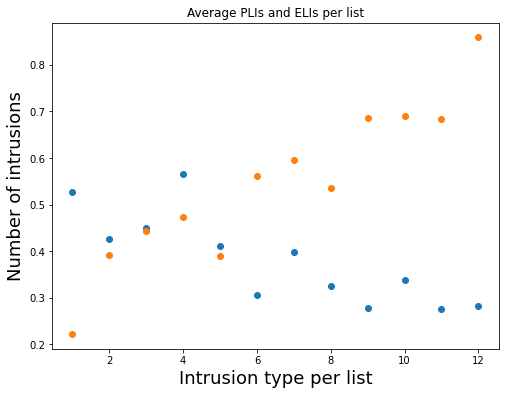

In [74]:
FR_list_df = list_df.query("experiment=='FR1'")
catFR_list_df = list_df.query("experiment=='catFR1'")

FR_sum_df = pd.DataFrame([])
for i in range(1,26):
    list_sel = FR_list_df[FR_list_df['list']==i]
    correc = np.mean(list_sel['number of correct recalls'])
    ELI = np.mean(list_sel['number of extra-list intrusions'])
    PLI = np.mean(list_sel['number of prior-list intrusions'])
    FR_sum_df = FR_sum_df.append({
        'experiment':list_sel.iloc[0]['experiment'],
        'list':i,
        'average correct recalls':correc,
        'average ELIs':ELI,
        'average PLIs':PLI
    }, ignore_index=True)

catFR_sum_df = pd.DataFrame([])
for i in range(1,13):
    list_sel = catFR_list_df[catFR_list_df['list']==i]
    correc = np.mean(list_sel['number of correct recalls'])
    ELI = np.mean(list_sel['number of extra-list intrusions'])
    PLI = np.mean(list_sel['number of prior-list intrusions'])
    catFR_sum_df = catFR_sum_df.append({
        'experiment':list_sel.iloc[0]['experiment'],
        'list':i,
        'average correct recalls':correc,
        'average ELIs':ELI,
        'average PLIs':PLI
    }, ignore_index=True)

lst = list(catFR_sum_df['list'])
ELIs = list(catFR_sum_df['average ELIs'])
PLIs = list(catFR_sum_df['average PLIs'])

plt.figure(figsize=(8,6))
plt.scatter(lst, ELIs)
plt.scatter(lst, PLIs)
plt.title('Average PLIs and ELIs per list')
# plt.legend([ELIs, PLIs],['ELIs', 'PLIs'])
plt.xlabel('Intrusion type per list',fontsize=18)
plt.ylabel('Number of intrusions',fontsize=18)

Text(0, 0.5, 'Number of PL intrusions')

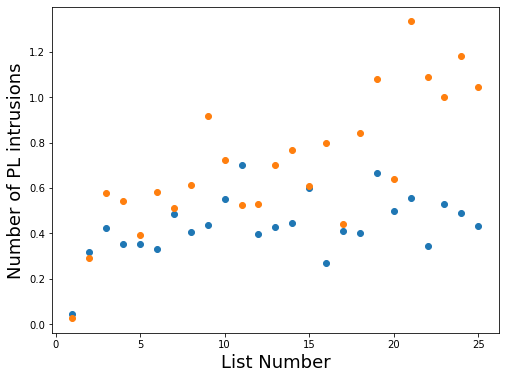

In [72]:
FR_list_df_high = FR_list_df.query("BAI>16")
FR_list_df_low = FR_list_df.query("BAI<10")

FR_sum_df_low = pd.DataFrame([])
for i in range(1,26):
    list_sel = FR_list_df_low[FR_list_df_low['list']==i]
    correc = np.mean(list_sel['number of correct recalls'])
    ELI = np.mean(list_sel['number of extra-list intrusions'])
    PLI = np.mean(list_sel['number of prior-list intrusions'])
    FR_sum_df_low = FR_sum_df_low.append({
        'experiment':list_sel.iloc[0]['experiment'],
        'list':i,
        'average correct recalls':correc,
        'average ELIs':ELI,
        'average PLIs':PLI
    }, ignore_index=True)
    
FR_sum_df_high = pd.DataFrame([])
for i in range(1,26):
    list_sel = FR_list_df_high[FR_list_df_high['list']==i]
    correc = np.mean(list_sel['number of correct recalls'])
    ELI = np.mean(list_sel['number of extra-list intrusions'])
    PLI = np.mean(list_sel['number of prior-list intrusions'])
    FR_sum_df_high = FR_sum_df_high.append({
        'experiment':list_sel.iloc[0]['experiment'],
        'list':i,
        'average correct recalls':correc,
        'average ELIs':ELI,
        'average PLIs':PLI
    }, ignore_index=True)

lst = list(FR_sum_df_low['list'])
low_ELIs = list(FR_sum_df_low['average ELIs'])
low_PLIs = list(FR_sum_df_low['average PLIs'])
high_ELIs = list(FR_sum_df_high['average ELIs'])
high_PLIs = list(FR_sum_df_high['average PLIs'])
y1 = low_PLIs
y2 = high_PLIs

plt.figure(figsize=(8,6))
plt.scatter(lst, y1)
plt.scatter(lst, y2)
# plt.legend([ELIs, PLIs],['ELIs', 'PLIs'])
plt.xlabel('List Number',fontsize=18)
plt.ylabel('Number of PL intrusions',fontsize=18)

In [73]:
catFR_df_filter = pd.DataFrame([])
FR_df_filter = pd.DataFrame([])
df_filter = pd.DataFrame([])

for i in trial_df.index:
    try:
        sub = trial_df.iloc[i]['subject']
        row = df_select[df_select['subject'] == sub]
        eli = trial_df.iloc[i]['number of extra-list intrusions']
        pli = trial_df.iloc[i]['number of prior-list intrusions']
        correc = trial_df.iloc[i]['number of correct recalls']
        allrec = trial_df.iloc[i]['total number of trials left']
        lists = trial_df.iloc[i]['number of lists']
        exp = trial_df.iloc[i]['experiment']
        PLI_scaled = float(pli/correc)
        ELI_scaled = float(eli/correc)
        correc_scaled = float(correc/lists)
#         PLI_scaled = float(pli/allrec)
#         ELI_scaled = float(eli/allrec)
#         correc_scaled = float(correc/allrec)
        if allrec > 0:
            df_filter = df_filter.append({
                'subject':sub,
                'experiment':exp,
                'correct recalls':correc,
                'ELIs':eli,
                'PLIs':pli,
                'total ints': eli+pli,
                'lists':lists,
                'correct recalls scaled':correc_scaled,
                'all recalls':allrec,
                'ELI scaled':ELI_scaled,
                'PLI scaled':PLI_scaled,
                'total scaled':ELI_scaled+PLI_scaled,
                'BAI':int(row['BAI'].values),
                'BDI':int(row['BDI'].values)
            }, ignore_index = True)
        else:
            print('removed row =', i, sub, exp)
    except:
        print('removed row =', i, sub, exp)


FR_df_filter = df_filter.query("experiment=='FR1'")
catFR_df_filter = df_filter.query("experiment=='catFR1'")
# for k in df_filter.index:
#     if df_filter.iloc[k]['experiment'] == 'FR1':
#         FR_df_filter = df_filter
#         df_filter = pd.DataFrame([])
#     elif exp == 'catFR1':
#         catFR_df_filter = df_filter
#         df_filter = pd.DataFrame([])
df_filter

/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


removed row = 3 R1015J FR1
removed row = 63 R1100D FR1
removed row = 64 R1100D FR1


,BAI,BDI,ELI scaled,ELIs,PLI scaled,PLIs,all recalls,correct recalls,correct recalls scaled,experiment,lists,subject,total ints,total scaled
0,2.0,1.0,0.035714,2.0,0.214286,12.0,70.0,56.0,2.434783,FR1,23.0,R1010J,14.0,0.250000
1,2.0,1.0,0.070175,4.0,0.105263,6.0,67.0,57.0,2.478261,FR1,23.0,R1010J,10.0,0.175439
2,2.0,12.0,0.000000,0.0,0.050000,4.0,84.0,80.0,4.000000,catFR1,20.0,R1013E,4.0,0.050000
3,7.0,15.0,0.062500,1.0,0.187500,3.0,20.0,16.0,1.777778,catFR1,9.0,R1015J,4.0,0.250000
4,0.0,4.0,0.016807,2.0,0.058824,7.0,128.0,119.0,4.760000,FR1,25.0,R1020J,9.0,0.075630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,11.0,8.0,0.021739,2.0,0.010870,1.0,95.0,92.0,7.666667,FR1,12.0,R1542J,3.0,0.032609
358,11.0,8.0,0.033333,3.0,0.022222,2.0,95.0,90.0,7.500000,FR1,12.0,R1542J,5.0,0.055556
359,11.0,8.0,0.063830,6.0,0.010638,1.0,101.0,94.0,7.833333,FR1,12.0,R1542J,7.0,0.074468
360,11.0,8.0,0.022472,2.0,0.011236,1.0,92.0,89.0,7.416667,catFR1,12.0,R1542J,3.0,0.033708


total PLI = 1810.0
total ELI = 1448.0
mean diff = 0.9822355126872561
median diff = 1.0


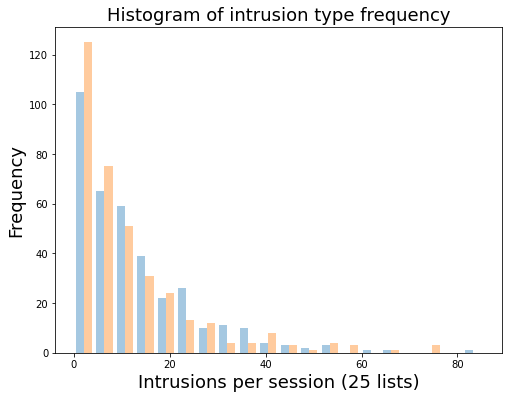

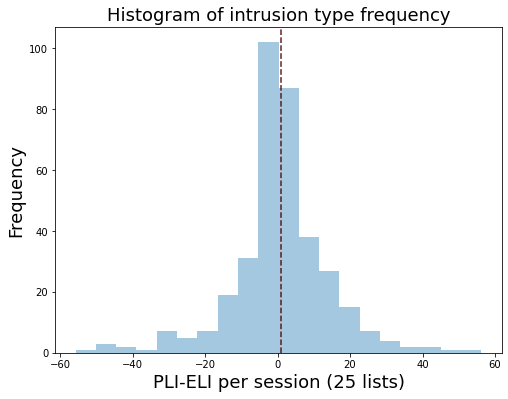

In [61]:
df_int = pd.DataFrame([])
for i in df_filter.index:
    sub = df_filter.iloc[i]['subject']
    exp = df_filter.iloc[i]['experiment']
    PLI = df_filter.iloc[i]['PLIs']
    ELI = df_filter.iloc[i]['ELIs']
    lists = df_filter.iloc[i]['lists']
    sPLI = float(PLI/lists)*25
    sELI = float(ELI/lists)*25
    diff = sPLI-sELI
    df_int = df_int.append({
        'subject':sub,
        'experiment':exp,
        'ELIs':eli,
        'PLIs':pli,
        'lists':lists,
        'ELIs per session':sELI,
        'PLIs per session':sPLI,
        'PLI minus ELI per session':diff,
    }, ignore_index=True)

total_PLI = np.sum(df_int['PLIs'])
total_ELI = np.sum(df_int['ELIs'])
PLI_list = list(df_int['PLIs per session'])
ELI_list = list(df_int['ELIs per session'])
diff_list = list(df_int['PLI minus ELI per session'])

plt.figure(figsize=(8,6))
int_hist = plt.hist((PLI_list, ELI_list), 20,alpha=0.4)
plt.xlabel('Intrusions per session (25 lists)',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
# plt.title('Time Between Report and Implant: '+ site,fontsize=18)
plt.title('Histogram of intrusion type frequency',fontsize=18)
# mean = np.mean(diff_list)
# median = np.median(diff_list)

# plt.axvline(x=mean, color='r', linestyle='--',alpha=0.5)
# plt.axvline(x=median, color='k', linestyle='--',alpha=0.6)
# print('mean =', mean)
# print('median =', median)
print('total PLI =', total_PLI)
print('total ELI =', total_ELI)

plt.figure(figsize=(8,6))
diff_hist = plt.hist(diff_list, 20,alpha=0.4)
plt.xlabel('PLI-ELI per session (25 lists)',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
# plt.title('Time Between Report and Implant: '+ site,fontsize=18)
plt.title('Histogram of intrusion type frequency',fontsize=18)
mean = np.mean(diff_list)
median = np.median(diff_list)

plt.axvline(x=mean, color='r', linestyle='--',alpha=0.5)
plt.axvline(x=median, color='k', linestyle='--',alpha=0.6)
print('mean diff =', mean)
print('median diff =', median)

# plt.text(med,15,'  Median: %.1f months' %(med/30))

In [62]:
#average across sessions from the same subject
FR_avg_df = pd.DataFrame([])
FR_sub_df = FR_df_filter['subject'].unique()
for sub in FR_sub_df:
    trials = FR_df_filter[FR_df_filter['subject']==sub]
    df_mean = trials.mean(axis=0)
    avg_eli = df_mean['ELI scaled']
    avg_pli = df_mean['PLI scaled']
    avg_int = df_mean['total scaled']
    avg_cor = df_mean['correct recalls scaled']
    exp = trials.iloc[0]['experiment']
    FR_avg_df = FR_avg_df.append({
        'subject':sub,
        'experiment':exp,
        'average ELIs':avg_eli,
        'average PLIs':avg_pli,
        'average ints': avg_int,
        'average correct recalls':avg_cor,
        'BAI':df_mean['BAI'],
        'BDI':df_mean['BDI']
        }, ignore_index = True)

catFR_avg_df = pd.DataFrame([])
catFR_sub_df = catFR_df_filter['subject'].unique()
for sub in catFR_sub_df:
    trials = catFR_df_filter[catFR_df_filter['subject']==sub]
    df_mean = trials.mean(axis=0)
    avg_eli = df_mean['ELI scaled']
    avg_pli = df_mean['PLI scaled']
    avg_int = df_mean['total scaled']
    avg_cor = df_mean['correct recalls scaled']
    exp = trials.iloc[0]['experiment']
    catFR_avg_df = catFR_avg_df.append({
        'subject':sub,
        'experiment':exp,
        'average ELIs':avg_eli,
        'average PLIs':avg_pli,
        'average ints': avg_int,
        'average correct recalls':avg_cor,
        'BAI':df_mean['BAI'],
        'BDI':df_mean['BDI']
        }, ignore_index = True)
catFR_avg_df

,BAI,BDI,average ELIs,average PLIs,average correct recalls,average ints,experiment,subject
0,2.0,12.0,0.000000,0.050000,4.000000,0.050000,catFR1,R1013E
1,7.0,15.0,0.062500,0.187500,1.777778,0.250000,catFR1,R1015J
2,3.0,6.0,0.042703,0.035240,3.361111,0.077944,catFR1,R1032D
3,2.0,7.0,0.000000,0.000000,7.000000,0.000000,catFR1,R1044J
4,7.0,8.0,0.001462,0.018270,7.840000,0.019732,catFR1,R1065J
...,...,...,...,...,...,...,...,...
67,5.0,6.0,0.062500,0.187500,3.200000,0.250000,catFR1,R1526J
68,18.0,16.0,0.025938,0.121146,9.638889,0.147085,catFR1,R1530J
69,12.0,21.0,0.229508,0.672131,5.083333,0.901639,catFR1,R1533J
70,24.0,17.0,0.064203,0.238134,4.001894,0.302337,catFR1,R1536J


In [63]:
# catFR_avg_df.iloc[1]['average ints']-
mean=np.mean(catFR_avg_df['average ints'])
std=np.std(catFR_avg_df['average ints'], ddof=1)
#(0.200000-catFR_avg_df['average ints'].mean())/catFR_avg_df['average ints'].std()
#(0.2000000-mean)/std
print(catFR_avg_df['average ints'].std(ddof=1))
print(std)

0.2941781857009772
0.2941781857009772


In [64]:
FR_stats = FR_avg_df[['average ELIs', 'average PLIs', 'average correct recalls', 'average ints']]
catFR_stats = catFR_avg_df[['average ELIs', 'average PLIs', 'average correct recalls', 'average ints']]
#FR_stats.apply(zscore)
# for i in FR_avg_df.index:
FR_df_zscore = (FR_stats - FR_stats.mean())/FR_stats.std()
catFR_df_zscore = (catFR_stats - catFR_stats.mean())/catFR_stats.std()

FR_avg_df['zELI'] = FR_df_zscore['average ELIs']
FR_avg_df['zPLI'] = FR_df_zscore['average PLIs']
FR_avg_df['zints'] = FR_df_zscore['average ints']
FR_avg_df['zcorrec'] = FR_df_zscore['average correct recalls']

catFR_avg_df['zELI'] = catFR_df_zscore['average ELIs']
catFR_avg_df['zPLI'] = catFR_df_zscore['average PLIs']
catFR_avg_df['zints'] = catFR_df_zscore['average ints']
catFR_avg_df['zcorrec'] = catFR_df_zscore['average correct recalls']
catFR_avg_df

full_df=pd.concat((FR_avg_df,catFR_avg_df))
full_df

,BAI,BDI,average ELIs,average PLIs,average correct recalls,average ints,experiment,subject,zELI,zPLI,zints,zcorrec
0,2.0,1.0,0.052945,0.159774,2.456522,0.212719,FR1,R1010J,-0.479464,-0.172577,-0.378402,-0.748568
1,0.0,4.0,0.016807,0.058824,4.760000,0.075630,FR1,R1020J,-0.561603,-0.509105,-0.575856,1.316076
2,3.0,1.0,0.301205,0.168675,3.320000,0.469880,FR1,R1022J,0.084808,-0.142908,-0.008004,0.025381
3,4.0,2.0,0.013514,0.013514,3.523810,0.027027,FR1,R1023J,-0.569088,-0.660150,-0.645861,0.208059
4,33.0,19.0,0.341463,0.195122,2.562500,0.536585,FR1,R1027J,0.176312,-0.054744,0.088075,-0.653578
...,...,...,...,...,...,...,...,...,...,...,...,...
67,5.0,6.0,0.062500,0.187500,3.200000,0.250000,catFR1,R1526J,-0.394368,0.317323,-0.129719,-0.605887
68,18.0,16.0,0.025938,0.121146,9.638889,0.147085,catFR1,R1530J,-0.565327,-0.138621,-0.479559,2.919676
69,12.0,21.0,0.229508,0.672131,5.083333,0.901639,catFR1,R1533J,0.386545,3.647430,2.085399,0.425317
70,24.0,17.0,0.064203,0.238134,4.001894,0.302337,catFR1,R1536J,-0.386405,0.665254,0.048192,-0.166816


r =  0.11424884773963341 p =  0.1667740415315089
y = 0.013728540880672706 *x +  -0.1399754607360481
r =  -0.03092981654257 p =  0.7090172106006984
y = -0.003716634865360452 *x +  0.03789460818803322
r =  0.031244443895454055 p =  0.7061927493375317
y = 0.0037544415878062666 *x +  -0.0382800834864842
r =  -0.016642338423909962 p =  0.8408862295238181
y = -0.00199980155531476 *x +  0.02038986856060797
r =  0.2704136477999195 p =  0.0008874238059981087
y = 0.02896382816594217 *x +  -0.3207548267836434
r =  0.1385721839302437 p =  0.09303071508049067
y = 0.014842375584920851 *x +  -0.1643692809708465
r =  0.21450680849583714 p =  0.008844449856012081
y = 0.022975683336423445 *x +  -0.2544401688405273
r =  -0.13982179744425866 p =  0.09009073997643528
y = -0.014976220867465717 *x +  0.1658515270390292


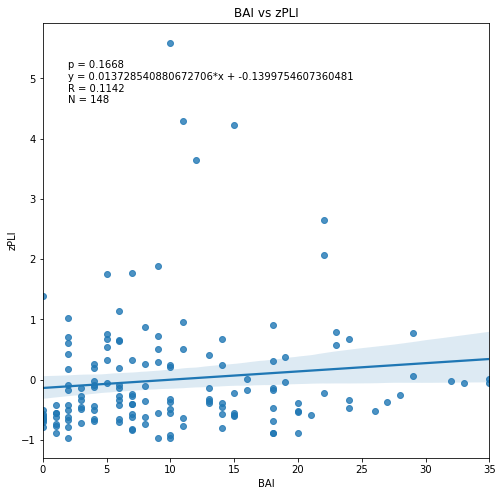

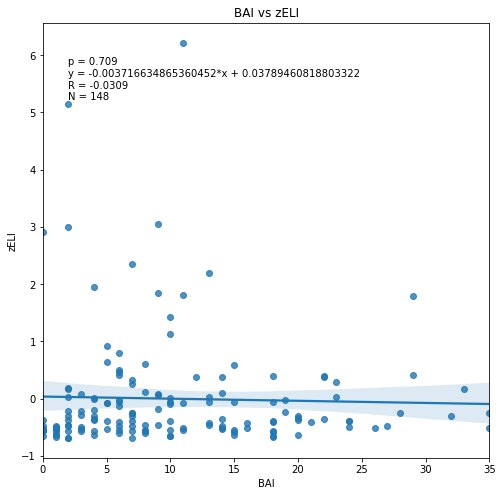

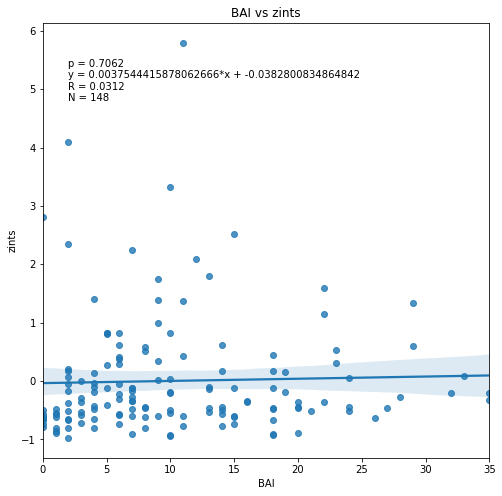

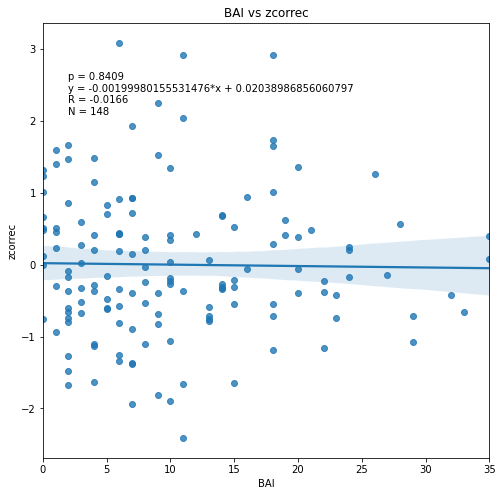

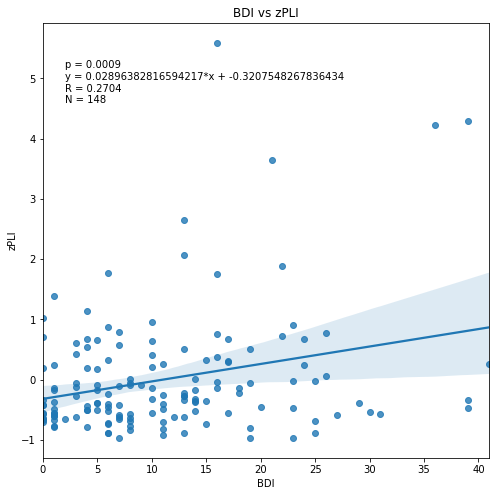

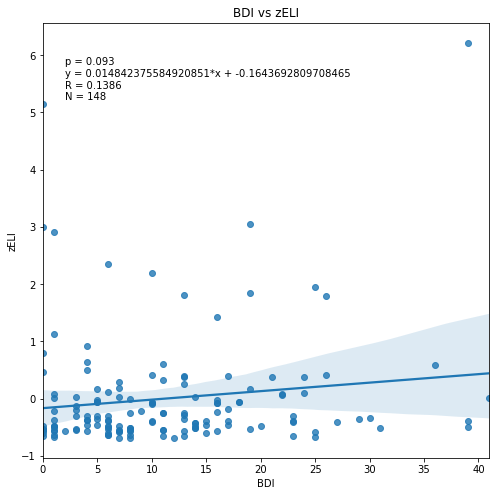

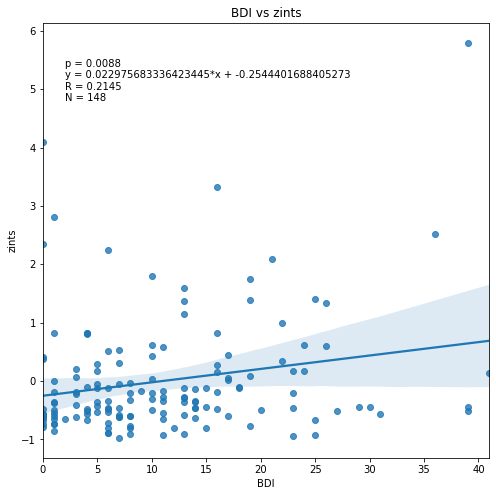

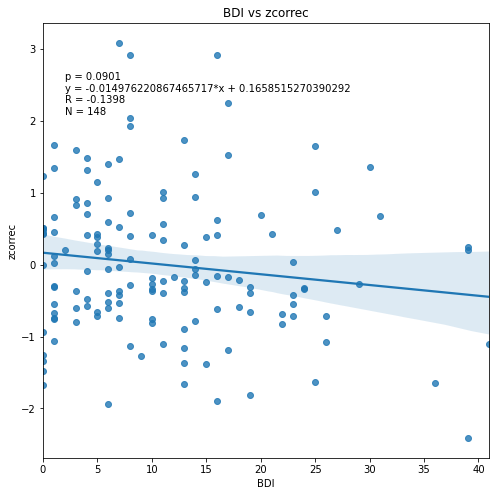

In [65]:
xs = ['BAI', 'BDI']
ys = ['zPLI', 'zELI', 'zints', 'zcorrec']
exp = 'both'

for xi in xs:
    for yi in ys:
 #'Average correct recalls'/'average ints'
        if exp == 'FR1':
            sel_df = FR_avg_df
        elif exp == 'catFR1':
            sel_df = catFR_avg_df
        elif exp == 'both':
            sel_df = full_df

        x = sel_df[xi]
        y = sel_df[yi]
        n = len(sel_df)

        coef = np.polyfit(x, y, 1)
        poly1d_fn = np.poly1d(coef)
        grad, inter, r, p, std_err = stats.linregress(x, y)

        plt.figure(figsize=(8, 8))
        # plt.scatter(x, y)
        # plt.plot(x, poly1d_fn(x), '--k')
        # max_x = round(x.max(axis = 0) + 5, 5)
        # max_y = round(y.max(axis = 0) + 5, 5)
        # plt.xticks(np.arange(0, max_x, 5))
        # plt.yticks(np.arange(0, max_y, 10))
        # plt.xlabel(xi)
        # plt.ylabel(yi)
        print('r = ',r, 'p = ', p)
        print('y =', grad, '*x + ', inter)
        plt.text(x.min()+2, y.max()-1, f"p = " + str(round(p, 4)) + '\n' + "y = " + str(grad) + "*x + " + str(inter) + '\n' + 'R = ' + str(round(r, 4)) + '\n' + 'N = ' + str(n))
        g = sb.regplot(data = df_filter, x=x, y=y)
        plt.title(xi + ' vs ' + yi)
        #plt.savefig(xi +' vs '+ yi + '.pdf')
        # ax.set_xlim(0, 25)
        # ax.set_xticks(range(0,25), 5)
        #add error bars, combine FR/pyFR, catFR separate, check out Courier
        #remove 5s and 4 intrusion criteria